<a href="https://colab.research.google.com/github/JPA-BERT/jpa-bert.github.io/blob/master/notebooks/02PyTorchTEXT_char_rnn_classification_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
    
このファイルは PyTorch のチュートリアルにあるファイル <https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html> を翻訳して，加筆修正したもの
です。

すぐれたチュートリアルの内容，コードを公開された Sean robertson および PyTorch 開発陣に敬意を表します。

- Original: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
- date: 2020-0811
- translated: 浅川伸一

---

In [ ]:
%load_ext autoreload
%autoreload 2


In [ ]:
# from https://github.com/dmlc/xgboost/issues/1715
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
%matplotlib inline

# ゼロからの NLP (自然言語処理): 文字レベル RNN による苗字名の分類

<!--# NLP From Scratch: Classifying Names with a Character-Level RNN-->

**Author**: [Sean Robertson](https://github.com/spro/practical-pytorch)

<!--
We will be building and training a basic character-level RNN to classify words. 
This tutorial, along with the following two, show how to do preprocess data for NLP modeling "from scratch", in particular not using many of the convenience functions of `torchtext`, so you can see how preprocessing for NLP modeling works at a low level.

A character-level RNN reads words as a series of characters - outputting a prediction and "hidden state" at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the  spelling:
-->

単語を分類するための基本的な文字レベルの RNN を構築して，訓練してみましょう。
このチュートリアルでは 後続する 2 つのチュートリアルと併せて NLP モデリングのためのデータの前処理を「ゼロから」行う方法を紹介します。

文字レベルの RNN は 単語を一連の文字として読み込み，各ステップで予測と「隠れ層の状態」を出力し，以前の隠さ層状態を次のステップに送り込ます。
最終的な予測値を出力とし，その単語がどのクラスに属しているかを出力します。

具体的には 18 の言語の苗字を数千個学習し，名前の綴りからその名前がどの言語の名前かを予測します。

```bash
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

**推薦図書:**
<!--**Recommended Reading:**-->

<!--I assume you have at least installed PyTorch, know Python, and understand Tensors:-->

このチュートリアルでは，最低限，インストール済 PyTorch，Python を知っていること，Tensors を理解していることを前提としています。

- https://pytorch.org/ インストール方法について<!--For installation instructions-->
- [deep_learning_60min_blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) PyTorch を始めるには <!--to get started with PyTorch in general-->
- [pytorch_with_examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html) 広範囲で深い概観 <!--for a wide and deep overview-->
- [former_torchies_tutorial](https://pytorch.org/tutorials/beginner/former_torchies_tutorial.html?highlight=former%20tutorials) Lua ユーザのためのチュートリアル <!--if you are former Lua Torch user-->

リカレントニューラルネットワークとその動作について有益な情報:
<!--It would also be useful to know about RNNs and how they work:-->

-  [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) 有益な事例の例証 <!--shows a bunch of real life examples -->
-  [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) 具体的には LSTM についてですが，一般的には RNN についても参考になります。<!--is about LSTMs specifically but also informative about RNNs in  general-->

## データの準備
<!--
## Preparing the Data
-->

### 覚書:
<!--
### Note:
-->

ここからデータをダウンロードして，カレントディレクトリに解凍してください
<!--
Download the data from [here](https://download.pytorch.org/tutorial/data.zip) and extract it to the current directory.
-->

``data/names`` ディレクトリは 18 個のテキストファイルがあります。各々 "\[Language\].txt" というファイル名です。
各ファイルは各行に一つ名前が書かれています。順番はランダマイズされていますが，ユニコードをアスキー文字に変換する必要があります。
<!--
Included in the ``data/names`` directory are 18 text files named as "[Language].txt". 
Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).
-->

最終的には言語ごとの名前のリストの辞書 ``{language: [names ...]}`` です。
一般的な変数 "category" と "line"（ここでは言語と名前を表す）は後で必要となる拡張性のためです。
<!--
We'll end up with a dictionary of lists of names per language, ``{language: [names ...]}``. 
The generic variables "category" and "line" (for language and name in our case) are used for later extensibility.
-->


In [ ]:
#訳注: 上で説明されている辞書をダウンロードして解凍。
#行頭の # を削除して，このセルを実行すること
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip   

--2020-08-10 23:57:19--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.50.63, 13.226.50.24, 13.226.50.98, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.50.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  13.1MB/s    in 0.2s    

2020-08-10 23:57:20 (13.1 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italia

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): 
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# ユニコード文字列をアスキー文字列へ変換, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))  # 訳注: `Slusarski` と画面に印字されれば正しく動作している

# 辞書 category_lines の作成，言語毎の苗字のリスト
category_lines = {}  # 訳注: 空の辞書の定義
all_categories = []  # 訳注: 空のリストの定義

# ファイルを一つ読み込み，行へと分割する
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Portuguese.txt', 'data/names/Greek.txt', 'data/names/Arabic.txt', 'data/names/Korean.txt', 'data/names/Italian.txt', 'data/names/Scottish.txt', 'data/names/Vietnamese.txt', 'data/names/Japanese.txt', 'data/names/German.txt', 'data/names/Russian.txt', 'data/names/Polish.txt', 'data/names/Czech.txt', 'data/names/Irish.txt', 'data/names/French.txt', 'data/names/Spanish.txt', 'data/names/English.txt', 'data/names/Dutch.txt', 'data/names/Chinese.txt']
Slusarski


<!--
Now we have ``category_lines``, a dictionary mapping each category (language) to a list of lines (names). We also kept track of ``all_categories`` (just a list of languages) and ``n_categories`` for later reference.
-->

これで ``category_lines`` ができました。
これは各カテゴリ(言語)と行(名前)のリストを対応付けた辞書です。
また 後で参照できるように ``all_categories`` (単に言語のリスト) と ``n_categories`` も保持しておきます。



In [ ]:
print(category_lines['Italian'][:5])
print(category_lines['Japanese'][:10]) 

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
['Abe', 'Abukara', 'Adachi', 'Aida', 'Aihara', 'Aizawa', 'Ajibana', 'Akaike', 'Akamatsu', 'Akatsuka']


## 名前をテンソルへ変換する
<!--
## Turning Names into Tensors

Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size ``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix ``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in batches - we're just using a batch size of 1 here.
-->

これですべての名前が整理できました。そこで，次にこの名前データをテンソルに変換します。

1 つの文字を表現するために サイズが ``<1 x n_letters>`` の  **ワンホットベクトル** を使います。
ワンホットベクトルとは，現在の文字のインデックスにあたる要素が 1 で他はすべて 0 で埋められたベクトルを指します。

単語を作るためには，ワンホットベクトルの集まりを 2次元の行列 ``<line_length x 1 x n_letters>`` に連接します。

この余分な1次元は、PyTorchがすべてバッチ単位であると仮定しているからです - ここではバッチサイズを 1 としています。




In [ ]:
import torch

# 文字 "a" のインデックスは 0, "b" のインデックスは 1 のように
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

print('-' * 79)
#print(letterToTensor('a'))
print('n_letters:', n_letters)
print('all_letters:', all_letters)
print('n_categories:', n_categories)
for i, cat in enumerate(all_categories):
    print(i+1, cat, len(category_lines[cat]))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])
-------------------------------------------------------------------------------
n_letters: 57
all_letters: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
n_categories: 18
1 Portuguese 74
2 Greek 203
3 Arabic 2000
4 Korean 94
5 Italian 709
6 Scottish 100
7 Vietnamese 73
8 Japanese 991
9 German 724
10 Russian 9408
11 Polish 139
12 Czech 519
13 Irish 232
14 French 277
15 Spanish 298
16 English 3668
17 Dutch 297
18 Chinese 268


## ネットワークの作成

autograd 導入以前は，
Torch でリカレントニューラルネットワークを作成するには，各繰り返し学習の各回で各層のパラメータをクローニングして保存する必要がありました。
各層は隠れ層の状態や勾配情報を保持していました。現在では計算グラフ自体によって完全に処理されるようになっています。
このことにより，RNN は，通常のフィードフォワード層として，非常に「純粋な」方法で実装可能になりました。

以下の RNN モジュールは（ほとんどが[PyTorch for Torchユーザチュートリアル](https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net) から複製されたものです。

<!--
## Creating the Network

Before autograd, creating a recurrent neural network in Torch involved cloning the parameters of a layer over several timesteps. 
The layers held hidden state and gradients which are now entirely handled by the graph itself. 
This means you can implement a RNN in a very "pure" way, as regular feed-forward layers.

This RNN module (mostly copied from [the PyTorch for Torch users tutorial](https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net) is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.
-->

<!--
.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:
-->
<img src="https://i.imgur.com/Z2xbySO.png" style="width:33%">


In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

<!--
To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). 
We'll get back the output (probability of each language) and a next hidden state (which we keep for the next step).
-->

このネットワークのステップを実行するには 入力（ここでは現在の文字のテンソル）と前の隠れ層状態（最初はゼロで初期化される）を渡す必要があります。
出力(入力文字列が，特定の言語の苗字である確率) と 次の時刻のために保持しておく隠れ状態を返します。




In [ ]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

#訳注: input は Python で input は予約語なので使わない方が良いと思います。


<!--
For the sake of efficiency we don't want to be creating a new Tensor for every step, so we will use ``lineToTensor`` instead of ``letterToTensor`` and use slices. 
This could be further optimized by pre-computing batches of Tensors.
-->

効率化重視のため，各ステップで新しいテンソルを作成したくないので，``letterToTensor`` の代わりに ``lineToTensor``を使い，スライスを使用します。
これはテンソルのバッチを事前に計算しておくことでさらに最適化できます。




In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9595, -2.8714, -2.8996, -2.8304, -2.8628, -2.9444, -2.8762, -2.9535,
         -2.9470, -2.9129, -2.8332, -2.9319, -2.8396, -2.8169, -2.8613, -2.8873,
         -2.9611, -2.8578]], grad_fn=<LogSoftmaxBackward>)


<!--
As you can see the output is a ``<1 x n_categories>`` Tensor, where every item is the likelihood of that category (higher is more likely).
-->

見ての通り 出力は ``<1 x n_categories>`` のテンソルで 各項目はそのカテゴリの尤度を表しています（高いほど可能性が高い）。




# 訓練

## 訓練の準備
<!--
# Training

## Preparing for Training
-->

<!--
Before going into training we should make a few helper functions. 
The first is to interpret the output of the network, which we know to be a likelihood of each category. 
We can use ``Tensor.topk`` to get the index of the greatest value:
-->

訓練に入る前に，ヘルパー関数をいくつか作る必要があります。
最初のヘルパー関数は，ネットワークの出力を解釈する関数で，各カテゴリの尤度を知るためです。
最大値を与えるインデックスを得るために ``Tensor.topk`` を使うことができます。
(訳注: Tensor.topk は「トップ k」を出力します)



In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('French', 13)


<!--
We will also want a quick way to get a training example (a name and its language):
-->
また，訓練事例（名前とその言語）を手っ取り早く手に入れる方法であるヘルパー関数も欲しいところです。




In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)
    


category = Japanese / line = Katayanagi
category = Dutch / line = Romeijnsen
category = Polish / line = Sokal
category = Portuguese / line = Santana
category = Portuguese / line = Rocha
category = Russian / line = Zheltov
category = Russian / line = Holomenko
category = Spanish / line = Araujo
category = Portuguese / line = Ferreiro
category = French / line = Page


# ネットワークの訓練
<!--
# Training the Network

Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last layer of the RNN is ``nn.LogSoftmax``.
-->

このネットワークを訓練するために必要なのは，たくさんの例を見せて，推測をさせ，間違っていたら教えてあげることだけです。

損失関数には ``nn.NLLLoss`` が適しています。
RNN の最後層は ``nn.LogSoftmax`` です。


In [ ]:
criterion = nn.NLLLoss()

訓練のループは以下の通りです:

- 入力テンソル，目標テンソルを作成する
- 隠れ層を 0 で初期化する
- 文字を読み込みで
   - 次の入力文字を処理するために隠れ層の状態を保持する
- 出力と目標とを比較する
- 誤差を逆伝播する
- 出力と損失関数値を返す

<!--
Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and
   -  Keep hidden state for next letter
-  Compare final output to target
-  Back-propagate
-  Return the output and loss
-->



In [ ]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

<!--
Now we just have to run that with a bunch of examples. 
Since the ``train`` function returns both the output and loss we can print its guesses and also keep track of loss for plotting. 
Since there are 1000s of examples we print only every ``print_every`` examples, and take an average of the loss.
-->

あとは，たくさんの例を使って実行するだけです。
``train`` 関数は出力と損失の両方を返すので，推測した結果を表示したり，プロットのために損失を追跡したりすることができます。
1000 個の例題があるので ``print_every`` のすべての例題だけを表示し，損失の平均を取ります。


In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.6752 Widerlechner / German ✗ (Czech)
10000 10% (0m 12s) 2.6334 O'Dowd / Scottish ✗ (Irish)
15000 15% (0m 18s) 1.1752 Chi / Korean ✓
20000 20% (0m 24s) 2.8773 To The First Page / Dutch ✗ (Russian)
25000 25% (0m 30s) 0.8927 Bao / Chinese ✓
30000 30% (0m 36s) 1.1903 Phi / Vietnamese ✓
35000 35% (0m 42s) 2.6599 Michaud / Scottish ✗ (French)
40000 40% (0m 48s) 0.1685 Lamberti / Italian ✓
45000 45% (0m 54s) 2.8924 Vlach / Irish ✗ (Czech)
50000 50% (1m 0s) 0.3665 Cremaschi / Italian ✓
55000 55% (1m 6s) 3.1778 Rendon / English ✗ (Spanish)
60000 60% (1m 12s) 0.6101 an / Vietnamese ✓
65000 65% (1m 18s) 1.3392 Tron / Vietnamese ✓
70000 70% (1m 24s) 2.0559 Schoonenburg / German ✗ (Dutch)
75000 75% (1m 30s) 0.2055 Milligan / Irish ✓
80000 80% (1m 36s) 0.6637 Ziyazov / Russian ✓
85000 85% (1m 42s) 2.0658 Kassis / Greek ✗ (Arabic)
90000 90% (1m 48s) 1.8995 Connolly / Scottish ✗ (Irish)
95000 95% (1m 54s) 0.3066 Veverka / Czech ✓
100000 100% (2m 0s) 0.0737 Mathghamhain / Irish ✓


# 結果のプロット
<!--
# Plotting the Results

Plotting the historical loss from ``all_losses`` shows the network learning:
-->

``all_losses`` から過去の損失をプロットすると ネットワーク学習の様子がわかります。


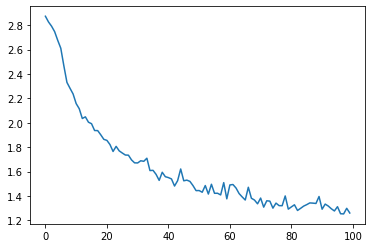

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## 結果の評価

ネットワークが異なるカテゴリに対してどの程度の性能を発揮するかを見るために 実際の言語（行）ごとに ネットワークがどの言語を推測しているか（列）を示す混同行列を作成します。
混同行列を計算するには ``evaluate()``を使ってネットワークにサンプルを走らせます。

<!--
## Evaluating the Results

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). 
To calculate the confusion matrix a bunch of samples are run through the network with ``evaluate()``, which is the same as ``train()`` minus the backprop.
-->



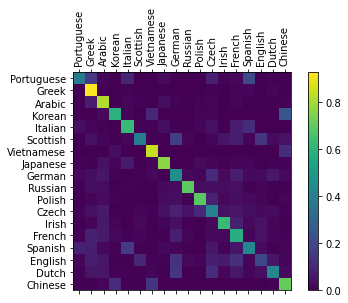

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()

ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

<!--
You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. 
It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).
-->

主軸を中心に，どの言語を誤って推測しているかを示す明るい点を選ぶことができます。
ギリシャ語では非常に良く，英語では非常に悪いようです（おそらく他の言語と重なっているためでしょう）。




## ユーザ入力の実行
<!--
## Running on User Input
-->



In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.73) Russian
(-0.89) Czech
(-2.81) Polish

> Jackson
(-1.17) Scottish
(-1.30) Russian
(-1.86) English

> Satoshi
(-1.07) Japanese
(-1.40) Arabic
(-1.76) Italian


このスクリプトの最終版
<https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification> では，上記のコードをいくつかのファイルに分割しました。

- ``data.py`` (ファイルのロード)
- ``model.py`` (RNN の定義)
- ``train.py`` (訓練の実行)
- ``predict.py`` (コマンドライン引数つきの``predict()`` の実行)
- ``server.py`` (bottle.py を使ってJSON API として予測 を保存)

<!--
The final versions of the scripts [in the Practical PyTorch
repo](https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification) split the above code into a few files:

- ``data.py`` (loads files)
- ``model.py`` (defines the RNN)
- ``train.py`` (runs training)
- ``predict.py`` (runs ``predict()`` with command line arguments)
- ``server.py`` (serve prediction as a JSON API with bottle.py)
-->


ネットワークを学習して保存するには ``train.py`` を実行してください。

予測結果を表示するためには 名前を指定して ``predict.py``を実行してください。

<!--
Run ``train.py`` to train and save the network.

Run ``predict.py`` with a name to view predictions:
-->

```bash
$ python predict.py Hazaki
(-0.42) Japanese
(-1.39) Polish
(-3.51) Czech
```

<!--
Run ``server.py`` and visit http://localhost:5533/Yourname to get JSON output of predictions.
-->

``server.py`` を実行して http://localhost:5533/Yourname にアクセスすると 予測結果の JSON 出力が得られます。



<!--
## Exercises

- Try with a different dataset of line -> category, for example:
    - Any word -> language
    - First name -> gender
    - Character name -> writer
    - Page title -> blog or subreddit

- Get better results with a bigger and/or better shaped network
    -Add more linear layers
    - Try the ``nn.LSTM`` and ``nn.GRU`` layers
    - Combine multiple of these RNNs as a higher level network
-->

## 演習

- 例えば line -> category の別のデータセットで試してみてください。
    - 任意の単語 -> 言語
    - 名字 -> 性別
    - キャラクター名 -> ライター
    - ページタイトル -> ブログとか レッドィットの下位掲示板

- より大きなネットワークとより良い形のネットワークを使って，より良い結果を得ることができます。
    - より多くの線形層を追加
    - ``nn.LSTM`` と ``nn.GRU``` の層を試す
    - これらの複数の RNN を高次ネットワークとして組み合わせる


